This is a reproduction of the main ideas from the 12th place solution. Description of the solution is available here :
    https://www.kaggle.com/c/LANL-Earthquake-Prediction/discussion/94500#latest-548989. Citations in the cells are taken from that discussion.

In [12]:
import os
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedStratifiedKFold,StratifiedKFold,KFold

from keras.models import Sequential
from keras.layers import Dense,BatchNormalization,Dropout
from keras.callbacks import ModelCheckpoint
from keras.optimizers import adam

from keras.layers.recurrent import GRU

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook
from sklearn.tree import export_graphviz
import lightgbm as lgb
from catboost import CatBoostRegressor
import xgboost as xgb
import scipy as sp

from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR

from scipy.fftpack import fft
from tsfresh.feature_extraction import feature_calculators

from scipy import signal

import gc
%matplotlib inline

"So basically the same as what Andrew did in his kernel https://www.kaggle.com/artgor/earthquakes-fe-more-features-and-samples"

In [2]:
train_X = pd.read_csv(os.path.join("../../extracted_feat/andrew",'train_features.csv'), dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})
test_df = pd.read_csv(os.path.join("../../extracted_feat/andrew",'test_features.csv'), dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})

In [3]:
train_y = pd.read_csv(os.path.join("../../extracted_feat/andrew",'y.csv'), dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})

In [4]:
eq = (train_y["target"].diff() > 0.5)
eq_groups_data = pd.DataFrame(index=train_y.index)
eq_groups_data["earthquake"] = 0 
eq_groups_data.loc[eq,"earthquake"] = 1
eq_groups_data["earthquake"]=eq_groups_data["earthquake"].cumsum()

"The wining CV strategy is based on the following earthquake splits:

- below 9s (class 0): 0, 3, 5, 6, 8, 12, 13
- between 10-12s (class 1): 1, 9, 10, 11, 15, 16
- above 12s (class 2): 2, 4, 7, 14"

In [5]:
eq_groups_class = pd.DataFrame([0, 3, 5, 6, 8, 12, 13, 1, 9, 10, 11, 15, 16,2, 4, 7, 14],columns=["eq"])
eq_groups_class.loc[eq_groups_class["eq"].isin([0, 3, 5, 6, 8, 12, 13]),"group"] = 0
eq_groups_class.loc[eq_groups_class["eq"].isin([1, 9, 10, 11, 15, 16]),"group"] = 1
eq_groups_class.loc[eq_groups_class["eq"].isin([2, 4, 7, 14]),"group"] = 2


In [6]:
scaler = StandardScaler()
scaler.fit(train_X)
train_X_scaled = pd.DataFrame(scaler.transform(train_X), columns=train_X.columns)
test_scaled = pd.DataFrame(scaler.transform(test_df), columns=test_df.columns)

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:3: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  app.launch_new_instance()
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:4: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.


"The CV is a repeated stratifiedKfold of n=2, repeat=5."

In [46]:
def train_lgb(X_val,y_val,X_train,y_train,test_df,params):
    model = lgb.LGBMRegressor(**params, n_estimators = 20000,n_jobs=-1)
    model.fit(X_train,y_train,
                  eval_set=[(X_val,y_val),(X_train,y_train)], 
                  verbose=5000,
                  early_stopping_rounds=1000)

#     oof[val_idx] += model.predict(X_val, num_iteration=model.best_iteration_)

#     predictions += model.predict(test_df, num_iteration=model.best_iteration_)
    return model

def train_xgb(X_val,y_val,X_train,y_train,test_df,xgb_params):
    
    model = xgb.XGBRegressor(params=xgb_params)
    model.fit(X_train,y_train,
              eval_set=[(X_val,y_val),(X_train,y_train)], 
              verbose=5000,eval_metric='mae',
              early_stopping_rounds=1000)
    
    best_iteration = model.get_booster().best_ntree_limit
#     oof[val_idx] += model.predict(X_val, ntree_limit=best_iteration)

#     predictions += model.predict(test_df, ntree_limit=best_iteration)
    return model

def seq_model(train_shape):
    model = Sequential()
    model.add(Dense(32,input_shape = (train_shape,),activation = 'relu'))

    model.add(Dropout(0.5))
    model.add(Dense(16,activation = 'relu'))
    model.add(BatchNormalization())
    
    model.add(Dense(1))
    
    model.compile(loss = 'mae',optimizer = 'adam')
    return model

def train_nn(X_val,y_val,X_train,y_train,test_df):
    
    
    model = seq_model(X_train.shape[1])
    mcp_save = ModelCheckpoint('.mdl_wtsPL.hdf5', 
                               save_best_only=True,
                               monitor='val_loss',
                               mode='min',verbose=1)
    model.fit(X_train,y_train,
              validation_data=(X_val,y_val), 
              verbose=0,epochs=50,callbacks=[mcp_save])
    model.load_weights(filepath = '.mdl_wtsPL.hdf5')
    
#     oof[val_idx] += model.predict(X_val).reshape(len(X_val),)
#     predictions += model.predict(test_df).reshape(len(test_df),)
    
    return model
def train_ridge(X_val,y_val,X_train,y_train,test_df):

    model = KernelRidge(alpha=1.0)
    
    model.fit(X_train,y_train)
        
#     oof[val_idx] += model.predict(X_val).reshape(len(X_val),)

#     predictions += model.predict(test_df).reshape(len(test_df),)
    return model

def train_svr(X_val,y_val,X_train,y_train,test_df):

    model = SVR(gamma='scale', C=1.0, epsilon=0.2)
    
    model.fit(X_train.values,y_train.values)

#     oof[val_idx] += model.predict(X_val).reshape(len(X_val),)
#     predictions += model.predict(test_df).reshape(len(test_df),)
    
    return model


def gru_model(predictions_shape):
    model = Sequential()

    model.add(GRU(8, input_shape=(1,predictions_shape)))

    model.add(Dense(4,activation='relu'))
    
    model.add(Dense(1))
    
    model.compile(loss = 'mae',optimizer=adam(lr=0.01))
    return model


In [44]:

folds = RepeatedStratifiedKFold(n_splits=2, n_repeats=5,)

xgb_params = {'eta': 0.01,
              'max_depth': 6,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'colsample_bylevel': 0.8,
              'colsample_bynode': 0.8,
              'lambda': 0.1,
              'alpha' : 0.1,

              'eval_metric': 'mae',
              'silent': True,
              'nthread': 4
             }
lgb_params = {'num_leaves': 4,
  'min_data_in_leaf': 5,
  'objective':'fair',
  'max_depth': -1,
  'learning_rate': 0.02,
  "boosting": "gbdt",
  'boost_from_average': True,
  "feature_fraction": 0.9,
  "bagging_freq": 1,
  "bagging_fraction": 0.5,
  "bagging_seed": 0,
  "metric": 'mae',
  "verbosity": -1,
  'max_bin': 500,
  'reg_alpha': 0,
  'reg_lambda': 0,
  'seed': 0,
  }

In [72]:
def train(train_X,train_y,test_df,folds,eq_groups_class,xgb_params,lgb_params):
    

    final_oof = pd.DataFrame(0,index=range(0,train_X.shape[0]),columns=["fold_0"])
    final_predictions = pd.DataFrame(0,index=test_df.index, columns=["lgb","nn"])
    
    fold_nr = 0
    for train_eq,val_eq in folds.split(eq_groups_class["eq"],eq_groups_class["group"]):
        if fold_nr % 2 == 0:
            train_idx = eq_groups_data["earthquake"].isin(train_eq)
            val_idx = eq_groups_data["earthquake"].isin(val_eq)
            X_train,y_train = train_X[train_idx],train_y[train_idx]
            X_val,y_val = train_X[val_idx],train_y[val_idx]
            
            predictors = ["lgb","xgb","nn","ridge","svr"]
            predictions = pd.DataFrame(0,index=test_df.index, columns= predictors)
            oof = pd.DataFrame(0,index=range(0,X_val.shape[0]),columns=predictors)
            
            kFolds = KFold(n_splits=2,)
            kfold_nr = 0
            
            for train_idx_1,val_idx_1 in kFolds.split(X_train,y_train):
                print("kfold " + str(kfold_nr))
                X_train_1,y_train_1 = X_train.iloc[train_idx_1],y_train.iloc[train_idx_1]
                X_val_1,y_val_1 = X_train.iloc[val_idx_1],y_train.iloc[val_idx_1]
 
                model_lgb = train_lgb(X_val_1,y_val_1,X_train_1,y_train_1,test_df,lgb_params)
                model_xgb = train_xgb(X_val_1,y_val_1,X_train_1,y_train_1,test_df,xgb_params)
                model_nn = train_nn(X_val_1,y_val_1,X_train_1,y_train_1,test_df)
                model_ridge = train_ridge(X_val_1,y_val_1,X_train_1,y_train_1,test_df)
                model_svr = train_svr(X_val_1,y_val_1,X_train_1,y_train_1,test_df)
                
                #predict second fold values
                oof["lgb"] += model_lgb.predict(X_val, num_iteration=model_lgb.best_iteration_)
                best_iteration = model_xgb.get_booster().best_ntree_limit
                oof["xgb"] += model_xgb.predict(X_val, ntree_limit=best_iteration)
                oof["nn"] += model_nn.predict(X_val).reshape(len(X_val),)
                oof["ridge"] += model_ridge.predict(X_val).reshape(len(X_val),)
                oof["svr"] += model_svr.predict(X_val).reshape(len(X_val),)
                
                predictions["lgb"] += model_lgb.predict(test_df, num_iteration=model_lgb.best_iteration_)
                predictions["xgb"] += model_xgb.predict(test_df, ntree_limit=best_iteration)
                predictions["nn"] += model_nn.predict(test_df).reshape(len(test_df),)
                predictions["ridge"] += model_ridge.predict(test_df).reshape(len(test_df),)
                predictions["svr"] += model_svr.predict(test_df).reshape(len(test_df),)
                kfold_nr += 1
                
            kFolds = KFold(n_splits=2,)
            kfold_nr = 0
            
            scaler = StandardScaler()
            scaler.fit(oof/2)
            oof_scaled = pd.DataFrame(scaler.transform(oof/2), columns=oof.columns)
            predictions_scaled = pd.DataFrame(scaler.transform(predictions/2), columns=predictions.columns)
            for train_idx_2,val_idx_2 in kFolds.split(oof_scaled,y_val):
                print("kfold validation " + str(kfold_nr))
                
                X_train_2,y_train_2 = oof_scaled.iloc[train_idx_2],y_val.iloc[train_idx_2]
                X_val_2,y_val_2 =  oof_scaled.iloc[val_idx_2],y_val.iloc[val_idx_2]
 
                model_lgb_final = train_lgb(X_val_2,y_val_2,X_train_2,y_train_2,predictions_scaled,lgb_params)
                model_nn_final = train_nn(X_val_2,y_val_2,X_train_2,y_train_2,predictions_scaled)      
                kfold_nr += 1
                final_predictions["lgb"] += model_lgb_final.predict(predictions, num_iteration=model_lgb_final.best_iteration_)
                final_predictions["nn"] += model_nn_final.predict(predictions).reshape(len(predictions),)
        fold_nr += 1
    return final_predictions/5


predictions = train(
    train_X_scaled,train_y,test_scaled,folds,eq_groups_class,xgb_params,lgb_params)


kfold 0
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[184]	training's l1: 1.02385	valid_0's l1: 3.34967
[19:01:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:6.23536	validation_1-mae:4.10734
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 1000 rounds.
[99]	validation_0-mae:3.37129	validation_1-mae:0.665395

Epoch 00001: val_loss improved from inf to 6.77031, saving model to .mdl_wtsPL.hdf5

Epoch 00002: val_loss improved from 6.77031 to 6.56729, saving model to .mdl_wtsPL.hdf5

Epoch 00003: val_loss improved from 6.56729 to 6.35893, saving model to .mdl_wtsPL.hdf5

Epoch 00004: val_loss improved from 6.35893 to 6.30314, saving model to .mdl_wtsPL.hdf5

Epoch 00005: val_loss improved from 6.30314 to 5.79083, saving model to .mdl_wtsPL.hdf5

Epoc

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



kfold validation 0
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[63]	training's l1: 2.01823	valid_0's l1: 1.85563

Epoch 00001: val_loss improved from inf to 5.80118, saving model to .mdl_wtsPL.hdf5

Epoch 00002: val_loss improved from 5.80118 to 5.46922, saving model to .mdl_wtsPL.hdf5

Epoch 00003: val_loss improved from 5.46922 to 5.10535, saving model to .mdl_wtsPL.hdf5

Epoch 00004: val_loss improved from 5.10535 to 4.80126, saving model to .mdl_wtsPL.hdf5

Epoch 00005: val_loss improved from 4.80126 to 4.42240, saving model to .mdl_wtsPL.hdf5

Epoch 00006: val_loss improved from 4.42240 to 3.93065, saving model to .mdl_wtsPL.hdf5

Epoch 00007: val_loss improved from 3.93065 to 3.43954, saving model to .mdl_wtsPL.hdf5

Epoch 00008: val_loss improved from 3.43954 to 2.74466, saving model to .mdl_wtsPL.hdf5

Epoch 00009: val_loss improved from 2.74466 to 2.40971, saving model to .mdl_wtsPL.hdf5

Epoch 00010: val_loss improved fr

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



kfold validation 0
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[48]	training's l1: 2.08794	valid_0's l1: 2.19685

Epoch 00001: val_loss improved from inf to 5.83761, saving model to .mdl_wtsPL.hdf5

Epoch 00002: val_loss improved from 5.83761 to 5.58603, saving model to .mdl_wtsPL.hdf5

Epoch 00003: val_loss improved from 5.58603 to 5.34391, saving model to .mdl_wtsPL.hdf5

Epoch 00004: val_loss improved from 5.34391 to 5.00981, saving model to .mdl_wtsPL.hdf5

Epoch 00005: val_loss improved from 5.00981 to 4.54510, saving model to .mdl_wtsPL.hdf5

Epoch 00006: val_loss improved from 4.54510 to 3.97170, saving model to .mdl_wtsPL.hdf5

Epoch 00007: val_loss improved from 3.97170 to 3.39247, saving model to .mdl_wtsPL.hdf5

Epoch 00008: val_loss improved from 3.39247 to 2.90887, saving model to .mdl_wtsPL.hdf5

Epoch 00009: val_loss improved from 2.90887 to 2.52862, saving model to .mdl_wtsPL.hdf5

Epoch 00010: val_loss improved fr

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



kfold validation 0
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[53]	training's l1: 1.99675	valid_0's l1: 1.93448

Epoch 00001: val_loss improved from inf to 4.52047, saving model to .mdl_wtsPL.hdf5

Epoch 00002: val_loss improved from 4.52047 to 4.23974, saving model to .mdl_wtsPL.hdf5

Epoch 00003: val_loss improved from 4.23974 to 3.98527, saving model to .mdl_wtsPL.hdf5

Epoch 00004: val_loss improved from 3.98527 to 3.73244, saving model to .mdl_wtsPL.hdf5

Epoch 00005: val_loss improved from 3.73244 to 3.41171, saving model to .mdl_wtsPL.hdf5

Epoch 00006: val_loss improved from 3.41171 to 2.84487, saving model to .mdl_wtsPL.hdf5

Epoch 00007: val_loss improved from 2.84487 to 2.30000, saving model to .mdl_wtsPL.hdf5

Epoch 00008: val_loss improved from 2.30000 to 1.89771, saving model to .mdl_wtsPL.hdf5

Epoch 00009: val_loss improved from 1.89771 to 1.71646, saving model to .mdl_wtsPL.hdf5

Epoch 00010: val_loss improved fr

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



kfold validation 0
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[513]	training's l1: 1.34421	valid_0's l1: 2.89652

Epoch 00001: val_loss improved from inf to 7.04432, saving model to .mdl_wtsPL.hdf5

Epoch 00002: val_loss improved from 7.04432 to 6.73609, saving model to .mdl_wtsPL.hdf5

Epoch 00003: val_loss improved from 6.73609 to 6.43925, saving model to .mdl_wtsPL.hdf5

Epoch 00004: val_loss improved from 6.43925 to 6.10673, saving model to .mdl_wtsPL.hdf5

Epoch 00005: val_loss improved from 6.10673 to 5.63897, saving model to .mdl_wtsPL.hdf5

Epoch 00006: val_loss improved from 5.63897 to 5.17326, saving model to .mdl_wtsPL.hdf5

Epoch 00007: val_loss improved from 5.17326 to 4.62668, saving model to .mdl_wtsPL.hdf5

Epoch 00008: val_loss improved from 4.62668 to 4.24189, saving model to .mdl_wtsPL.hdf5

Epoch 00009: val_loss improved from 4.24189 to 3.89173, saving model to .mdl_wtsPL.hdf5

Epoch 00010: val_loss improved f

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



kfold validation 0
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[59]	training's l1: 1.41327	valid_0's l1: 1.50242

Epoch 00001: val_loss improved from inf to 4.63036, saving model to .mdl_wtsPL.hdf5

Epoch 00002: val_loss improved from 4.63036 to 4.42863, saving model to .mdl_wtsPL.hdf5

Epoch 00003: val_loss improved from 4.42863 to 4.16656, saving model to .mdl_wtsPL.hdf5

Epoch 00004: val_loss improved from 4.16656 to 3.96675, saving model to .mdl_wtsPL.hdf5

Epoch 00005: val_loss improved from 3.96675 to 3.72202, saving model to .mdl_wtsPL.hdf5

Epoch 00006: val_loss improved from 3.72202 to 3.34709, saving model to .mdl_wtsPL.hdf5

Epoch 00007: val_loss improved from 3.34709 to 3.04047, saving model to .mdl_wtsPL.hdf5

Epoch 00008: val_loss improved from 3.04047 to 2.58492, saving model to .mdl_wtsPL.hdf5

Epoch 00009: val_loss improved from 2.58492 to 2.14056, saving model to .mdl_wtsPL.hdf5

Epoch 00010: val_loss improved fr

In [78]:
(predictions/5)

,lgb,nn
0,3.704302,8.911352
1,3.704302,9.191869
2,3.704302,10.569861
3,3.704302,14.779964
4,3.704302,12.109632
5,3.681006,6.401448
6,3.704302,13.619324
7,3.704302,7.923401
8,3.704302,8.897397
9,3.642508,5.549753


6.2

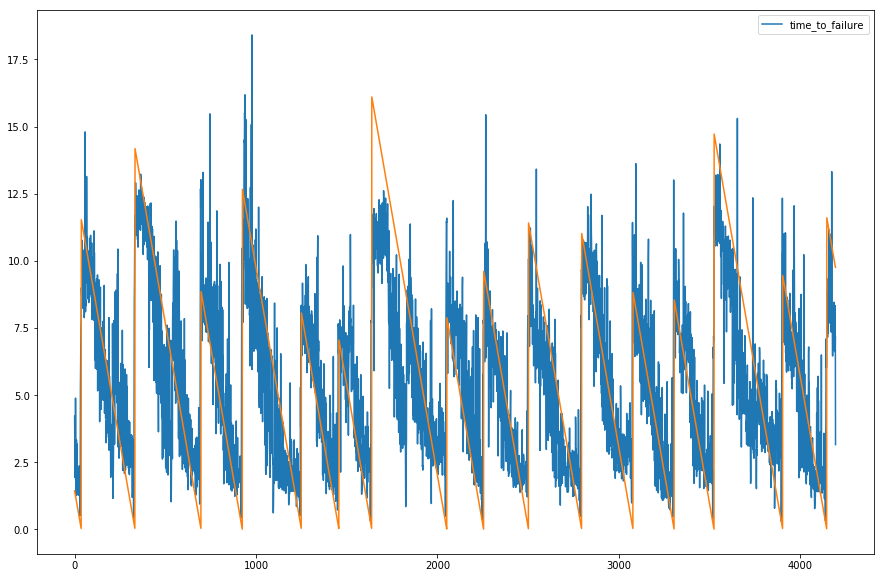

In [280]:
fig,ax = plt.subplots(figsize=(15,10))
(final_oof/5).plot(ax=ax)
plt.plot(train_y)
sub = pd.read_csv(os.path.join("../../extracted_feat/andrew",'submission.csv'))
sub["time_to_failure"] = ((final_pred/10)/(final_pred/10).mean())*6.2
mean_absolute_error(train_y,final_oof/5)
sub.to_csv("../../submissions/kfolds/top_solutions/12th-place.csv",index=False)
sub["time_to_failure"].mean()

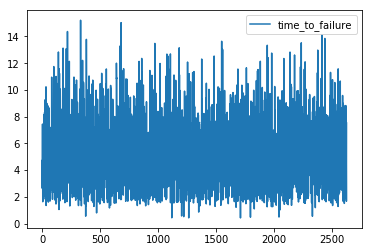

In [269]:
(final_pred/10).plot()